### Libraries

In [4]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import List, Tuple


## Utils functions

In [114]:
def evaluate_policy(env, q_table, episodes=10) -> Tuple[float, float]:
    """Evaluate the Q-learning agent for a certain number of episodes and return average reward and steps."""
    total_reward, total_length = 0, 0

    for _ in range(episodes):
        state = env.reset(seed=1234)[0]
        done = truncated = False
        episode_reward, steps = 0, 0

        while not (done):
            action = np.argmax(q_table[state])
            state, reward, done, truncated, info = env.step(action)
            episode_reward += reward
            steps += 1
            if steps > 500:
                # print("eval broke")
                break
            

        total_reward += episode_reward
        total_length += steps

    avg_reward = total_reward / episodes
    avg_length = total_length / episodes
    return avg_reward, avg_length

def moving_average(data: List[float], window_size: int) -> List[float]:
    """Compute the moving average of a list of numbers."""
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

def sigmoid(x):
    """Compute the sigmoid function."""
    return 1 / (1 + np.exp(-x))

def _plot_evaluation(rewards: List[float], lengths: List[int], epsilons: List[float], title: str, window_size: int = 10):
    """Plot the exponential moving average of rewards, lengths, and epsilon values."""
    # Calculate moving averages
    rewards_ma = moving_average(rewards, window_size)
    lengths_ma = moving_average(lengths, window_size)
    # epsilons_ma = moving_average(epsilons, window_size)

    # rewards_sig = sigmoid(rewards_ma) * 2 - 1
    # lengths_sig = sigmoid(lengths_ma) * 2 - 1
    # epsilons_sig = sigmoid(epsilons_ma) * 2 - 1

    plt.figure(figsize=(18, 5))

    # Plot for average cumulative rewards
    plt.subplot(1, 3, 1)
    plt.plot(rewards_ma, label='Average Reward')  # Add 'o' marker
    plt.title("Average Cumulative Reward (Moving Average)")
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Average Cumulative Reward")
    plt.legend()

    # Plot for average steps
    plt.subplot(1, 3, 2)
    plt.plot(lengths_ma, label='Average Steps')  # Add 'o' marker
    plt.title("Average Steps (Moving Average)")
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Average Steps")
    plt.legend()

    # Plot for epsilon changes
    plt.subplot(1, 3, 3)
    plt.plot(epsilons,  label='Epsilon')  # Add 'o' marker
    plt.title("Epsilon Decay")
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Epsilon Value")
    plt.legend()

    plt.tight_layout()
    # plt.suptitle(title)  # Adds a title to the entire figure
    plt.show()

def universal_initialize_q_table(env):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    q_table = np.zeros((n_states, n_actions))
    return q_table

def epsilon_greedy_policy(Q, state, epsilon, env):
    """Choose an action based on epsilon-greedy policy."""
    if np.random.uniform(0, 1) < epsilon:
        return env.action_space.sample()
    else:
        return np.argmax(Q[state, :])
    
def average_results(results: List[Tuple[List[float], List[float], List[float]]], num_evals: int) -> Tuple[List[float], List[float], List[float]]:
    """Average the rewards, lengths, and epsilons across multiple training runs."""
    avg_rewards = np.zeros(num_evals)
    avg_lengths = np.zeros(num_evals)
    avg_epsilons = np.zeros(num_evals)

    for rewards, lengths, epsilons in results:
        avg_rewards += np.array(rewards)
        avg_lengths += np.array(lengths)
        avg_epsilons += np.array(epsilons)

    avg_rewards /= len(results)
    avg_lengths /= len(results)
    avg_epsilons /= len(results)

    return avg_rewards.tolist(), avg_lengths.tolist(), avg_epsilons.tolist()    


def initialize_random_q_table(env):
    q_table = np.random.uniform(low=0, high=0.1, size=(env.observation_space.n, env.action_space.n))
    q_table[(env.desc == b"G").flatten()] = 0  # Assuming 'G' is the goal/terminal state
    return q_table


def plot_metrics(rewards: List[float], lengths: List[int]):
    # Plotting
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(rewards)
    plt.title("Average Cumulative Reward vs. Evaluation Episodes")
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Average Cumulative Reward")

    plt.subplot(1, 2, 2)
    plt.plot(lengths)
    plt.title("Average Steps vs. Evaluation Episodes")
    plt.xlabel("Evaluation Episode")
    plt.ylabel("Average Steps")
    plt.tight_layout()
    plt.show()


## Environment Creation

In [6]:
# Create the FrozenLake environment
env = gym.make("FrozenLake-v1", is_slippery=False)
env.action_space.seed(1234)
np.random.seed(1234)


In [3]:
# Create the 4x4 FrozenLake environment
env = gym.make("FrozenLake-v1",is_slippery=False)
env.action_space.seed(1234)
np.random.seed(1234)


## Train Q-learning

In [39]:
def train_q_learing(
    env: gym.Env,
    alpha: float = 0.1,
    gamma: float = 0.99,
    initial_epsilon: float = 1.0,
    min_epsilon: float = 0.01,
    epsilon_decay: float = 0.9999,
    episodes: int = 20000,
    eval_every: int = 100,
    eval_episodes: int = 20,
) -> Tuple:
    """Trains an agent using the Q-learning algorithm on a specified environment.

    This function initializes a Q-table with random values and iteratively updates it based on the agent's experiences in the environment. The exploration rate (epsilon) decreases over time, allowing the agent to transition from exploring the environment to exploiting the learned Q-values. The function periodically evaluates the agent's performance using the current Q-table and returns the training history.

    Args:
        env (gym.Env): The environment to train the agent on. Must be compatible with the OpenAI Gym interface.
        alpha (float): The learning rate, determining how much of the new Q-value estimate to use. Defaults to 0.1.
        gamma (float): The discount factor, used to balance immediate and future rewards. Defaults to 0.99.
        initial_epsilon (float): The initial exploration rate, determining how often the agent explores random actions. Defaults to 1.0.
        min_epsilon (float): The minimum exploration rate after decay. Defaults to 0.01.
        epsilon_decay (float): The factor used for exponential decay of epsilon. Defaults to 0.995.
        episodes (int): The total number of episodes to train the agent for. Defaults to 10000.
        eval_every (int): The frequency (in episodes) at which to evaluate the agent's performance. Defaults to 100.
        eval_episodes (int): The number of episodes to use for each evaluation. Defaults to 10.

    Returns:
        tuple: A tuple containing three elements:
            - np.ndarray: The final Q-table learned by the agent.
            - list: A history of average rewards obtained by the agent during evaluation periods.
            - list: A history of average step lengths taken by the agent during evaluation periods.

    """

    q_table = initialize_random_q_table(env)
    env.reset(seed=1234)
    epsilon = initial_epsilon
    rewards, lengths, epsilons = [], [], []
    first = True
    total_steps = 0

    for episode in range(episodes):
        state = env.reset(seed=1234)[0]
        done = False

        while not done:
            # Epsilon-greedy action selection
            action = epsilon_greedy_policy(q_table, state, epsilon, env)

            next_state, reward, done, _, _ = env.step(action)

            # Q-Learning update rule
            q_table[state, action] = q_table[state, action] + alpha * (
                reward + gamma * np.max(q_table[next_state, :]) - q_table[state, action]
            )
            state = next_state

            total_steps += 1

        # Epsilon decay
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

        # Evaluation
        if (episode + 1) % eval_every == 0:
            avg_reward, avg_length = evaluate_policy(env, q_table, eval_episodes)
            if first and avg_reward:
                first = False
                print("The first episode reached to 1 is", episode)
                print("The length is ", avg_length)
                print("The eps is ", epsilon)

            rewards.append(avg_reward)
            lengths.append(avg_length)
            epsilons.append(epsilon)
            # print(f"Episode: {episode + 1}, Avg. Reward: {avg_reward}, Avg. Length: {avg_length}, Epsilon: {epsilon}")

    print("Training completed.")
    return q_table, rewards, lengths, epsilons, total_steps


## Map of 4x4

Training run 1
Episode: 1, Avg. Reward: 0.0, Avg. Length: 501.0, Epsilon: 0.9999
Episode: 2, Avg. Reward: 0.0, Avg. Length: 501.0, Epsilon: 0.9998000100000001
Episode: 3, Avg. Reward: 0.0, Avg. Length: 501.0, Epsilon: 0.9997000299990001
Episode: 4, Avg. Reward: 0.0, Avg. Length: 501.0, Epsilon: 0.9996000599960002
Episode: 5, Avg. Reward: 0.0, Avg. Length: 501.0, Epsilon: 0.9995000999900007
Episode: 6, Avg. Reward: 0.0, Avg. Length: 501.0, Epsilon: 0.9994001499800017
Episode: 7, Avg. Reward: 0.0, Avg. Length: 501.0, Epsilon: 0.9993002099650037
Episode: 8, Avg. Reward: 0.0, Avg. Length: 501.0, Epsilon: 0.9992002799440072
Episode: 9, Avg. Reward: 0.0, Avg. Length: 501.0, Epsilon: 0.9991003599160128
Episode: 10, Avg. Reward: 0.0, Avg. Length: 501.0, Epsilon: 0.9990004498800211
Episode: 11, Avg. Reward: 0.0, Avg. Length: 501.0, Epsilon: 0.9989005498350332
Episode: 12, Avg. Reward: 0.0, Avg. Length: 501.0, Epsilon: 0.9988006597800497
Episode: 13, Avg. Reward: 0.0, Avg. Length: 501.0, Epsilon

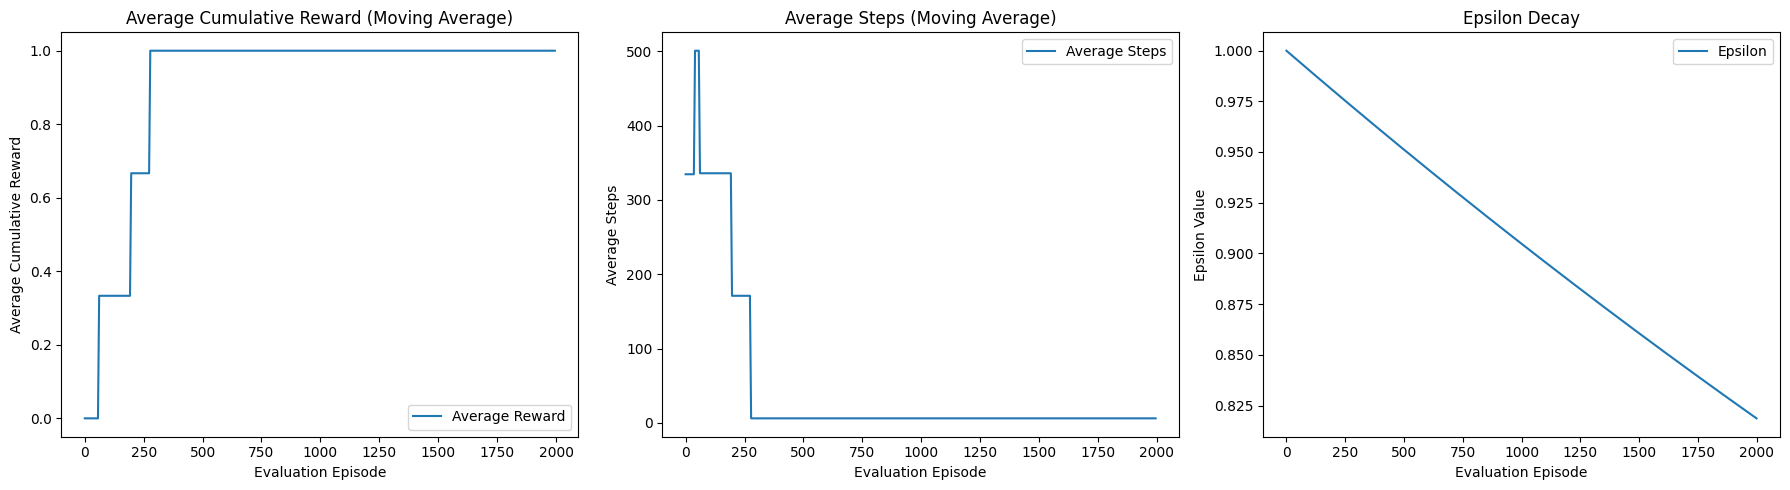

Final Q-Table by taking 15924 steps:
[[9.31954969e-01 9.25167492e-01 9.42098970e-01 9.32114213e-01]
 [9.31754464e-01 7.26973858e-02 9.52018970e-01 9.41114454e-01]
 [9.41051973e-01 9.62623880e-01 9.38415048e-01 9.51290513e-01]
 [9.49952572e-01 8.82577231e-02 9.26848446e-01 9.35113513e-01]
 [9.22272034e-01 9.35661606e-01 7.26973858e-02 9.31565070e-01]
 [4.24731493e-02 6.67164672e-02 7.34317028e-02 2.23366916e-02]
 [7.26973679e-02 9.73797164e-01 8.82577245e-02 9.49135579e-01]
 [1.21154584e-02 2.60086529e-02 8.91492212e-02 7.28327381e-02]
 [9.17562340e-01 8.57876040e-02 9.50205334e-01 9.09645300e-01]
 [9.15710016e-01 9.65222122e-01 9.53496316e-01 7.26780872e-02]
 [9.40286363e-01 9.86156364e-01 6.85564163e-02 9.53213621e-01]
 [3.72751202e-02 6.65148531e-02 6.92470955e-02 1.82664110e-02]
 [8.66541520e-02 5.25219358e-04 5.28707339e-02 6.70489242e-02]
 [8.58043450e-02 9.17443701e-01 9.83334020e-01 8.61242782e-01]
 [9.28212529e-01 9.45300917e-01 9.98858957e-01 9.60894426e-01]
 [0.00000000e+00 0

In [34]:
env = gym.make('FrozenLake-v1', is_slippery=False)

num_runs = 3
all_results = []

for run in range(num_runs):
    print(f"Training run {run + 1}")
    q_table, rewards, lengths, epsilons, total_steps = train_q_learing(env, episodes=2000, eval_episodes=1, eval_every=1)
    all_results.append((rewards, lengths, epsilons))

avg_rewards, avg_lengths, avg_epsilons = average_results(all_results, num_evals=len(all_results[0][0]))

_plot_evaluation(avg_rewards, avg_lengths, avg_epsilons, title="Q-learning FL4x4 (Averaged over 3 runs)", window_size=5)
print(f"Final Q-Table by taking {total_steps} steps:")
print(q_table)

## Map of 8x8

Training run 1
The first episode reached to 1 is 2616
The length is  14.0
The eps is  0.7697318389676381
Training completed.
Training run 2
Training completed.
Training run 3
The first episode reached to 1 is 1891
The length is  14.0
The eps is  0.8276131361687454
Training completed.


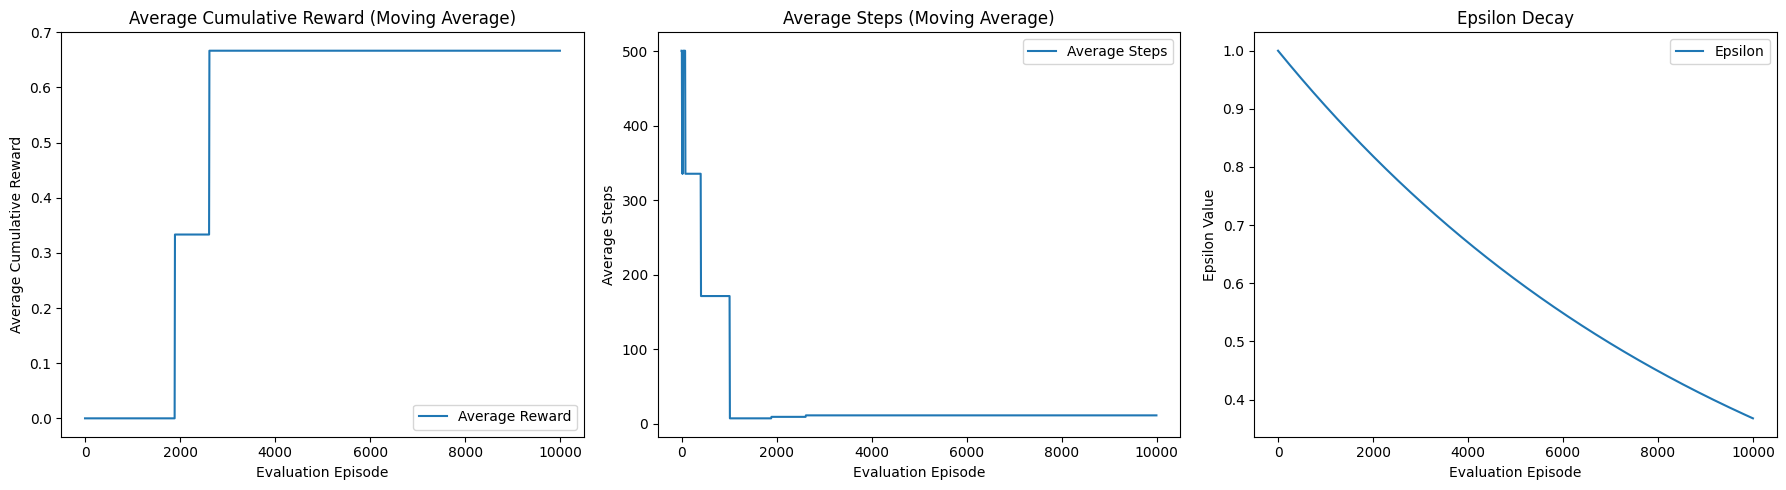

Final Q-Table by taking 230762 steps:
[[8.68745813e-01 8.77521023e-01 8.77521023e-01 8.68745813e-01]
 [8.68745813e-01 8.86384872e-01 8.86384872e-01 8.77521023e-01]
 [8.77521023e-01 8.95338254e-01 8.95338254e-01 8.86384872e-01]
 [8.86384872e-01 9.04382075e-01 9.04382075e-01 8.95338254e-01]
 [8.95338254e-01 9.13517247e-01 9.13517247e-01 9.04382075e-01]
 [9.04382052e-01 9.22744694e-01 9.22744686e-01 9.13517243e-01]
 [9.13499097e-01 9.32065348e-01 9.31107629e-01 9.22717252e-01]
 [9.19707035e-01 9.41479902e-01 9.17277573e-01 9.25663942e-01]
 [8.77521023e-01 8.68745813e-01 8.86384872e-01 8.68745813e-01]
 [8.77521023e-01 8.77521023e-01 8.95338254e-01 8.77521023e-01]
 [8.86384872e-01 8.86384872e-01 9.04382075e-01 8.86384872e-01]
 [8.95338254e-01 3.44853354e-02 9.13517247e-01 8.95338254e-01]
 [9.04382075e-01 9.22744694e-01 9.22744694e-01 9.04382075e-01]
 [9.13517247e-01 9.32065348e-01 9.32065348e-01 9.13517247e-01]
 [9.22744694e-01 9.41480149e-01 9.41480149e-01 9.22744694e-01]
 [9.32065072e-01 

In [40]:
env = gym.make('FrozenLake-v1', map_name='8x8', is_slippery=False)

num_runs = 3
all_results = []

for run in range(num_runs):
    print(f"Training run {run + 1}")
    q_table, rewards, lengths, epsilons, total_steps = train_q_learing(env, episodes=10000, eval_episodes=1, eval_every=1)
    all_results.append((rewards, lengths, epsilons))

avg_rewards, avg_lengths, avg_epsilons = average_results(all_results, num_evals=len(all_results[0][0]))

_plot_evaluation(avg_rewards, avg_lengths, avg_epsilons, title="Q-learning FL4x4 (Averaged over 3 runs)", window_size=5)
print(f"Final Q-Table by taking {total_steps} steps:")
print(q_table)

## Train DQL

In [41]:
def train_double_q_learning(
    env: gym.Env,
    alpha: float = 0.1,
    gamma: float = 0.99,
    initial_epsilon: float = 0.999,
    min_epsilon: float = 0.01,
    epsilon_decay: float = 0.9999,
    episodes: int = 20000,
    eval_every: int = 100,
    eval_episodes: int = 20,
) -> Tuple[np.ndarray, np.ndarray, List[float], List[int]]:
    """
    Trains an agent using the Double Q-learning algorithm on a specified environment.

    Args:
        env (gym.Env): The environment to train the agent on.
        alpha (float): Learning rate.
        gamma (float): Discount factor for future rewards.
        initial_epsilon (float): Starting value for epsilon in the epsilon-greedy strategy.
        min_epsilon (float): Minimum value that epsilon can decay to over time.
        epsilon_decay (float): Rate at which epsilon decays after each episode.
        episodes (int): Total number of training episodes.
        eval_every (int): Frequency of evaluation phases during training.
        eval_episodes (int): Number of episodes to run during each evaluation phase.

    Returns:
        Tuple[np.ndarray, np.ndarray, List[float], List[int]]: A tuple containing:
            - The final Q-table A learned by the agent.
            - The final Q-table B learned by the agent.
            - A history of average rewards obtained during evaluation periods.
            - A history of average step lengths taken during evaluation periods.
    """

    q_table_a = initialize_random_q_table(env)
    q_table_b = initialize_random_q_table(env)

    epsilon = initial_epsilon
    rewards, lengths, epsilons = [], [], []
    env.reset(seed=1234)
    first = True
    total_steps = 0
    
    for episode in range(episodes):
        state = env.reset()[0]
        done = False

        while not done:
            action = epsilon_greedy_policy(Q=q_table_a+q_table_b/2, state=state, epsilon=epsilon, env=env)

            next_state, reward, done, _, _ = env.step(action)
            if np.random.rand() < 0.5:
                best_next_action = np.argmax(q_table_a[next_state, :])
                td_target = reward + gamma * q_table_b[next_state, best_next_action]
                q_table_a[state, action] += alpha * (
                    td_target - q_table_a[state, action]
                )

            else:
                best_next_action = np.argmax(q_table_b[next_state, :])
                td_target = reward + gamma * q_table_a[next_state, best_next_action]
                q_table_b[state, action] += alpha * (
                    td_target - q_table_b[state, action]
                )

            total_steps += 1
            state = next_state
            # If done (if we're dead) : finish episode
            if done:
                break

        epsilon = max(min_epsilon, epsilon_decay * epsilon)

        if (episode + 1) % eval_every == 0:
            avg_reward, avg_length = evaluate_policy(
                env, q_table_a + q_table_b, eval_episodes
            )
            if first and avg_reward:
                first = False
                print("The first episode reached to 1 is ", episode)
                print("The length is ", avg_length)
                print("The epsilon is ", epsilon)
            rewards.append(avg_reward)
            lengths.append(avg_length)
            epsilons.append(epsilon)

    print("Double Q-learning training completed.")
    return q_table_a, q_table_b, rewards, lengths, epsilons, total_steps


Training run 1
The first episode reached to 1 is  1060
The length is  6.0
The epsilon is  0.8984306088931978
Double Q-learning training completed.
Training run 2
The first episode reached to 1 is  784
The length is  6.0
The epsilon is  0.9235739325951412
Double Q-learning training completed.
Training run 3
The first episode reached to 1 is  1110
The length is  6.0
The epsilon is  0.8939494440351232
Double Q-learning training completed.


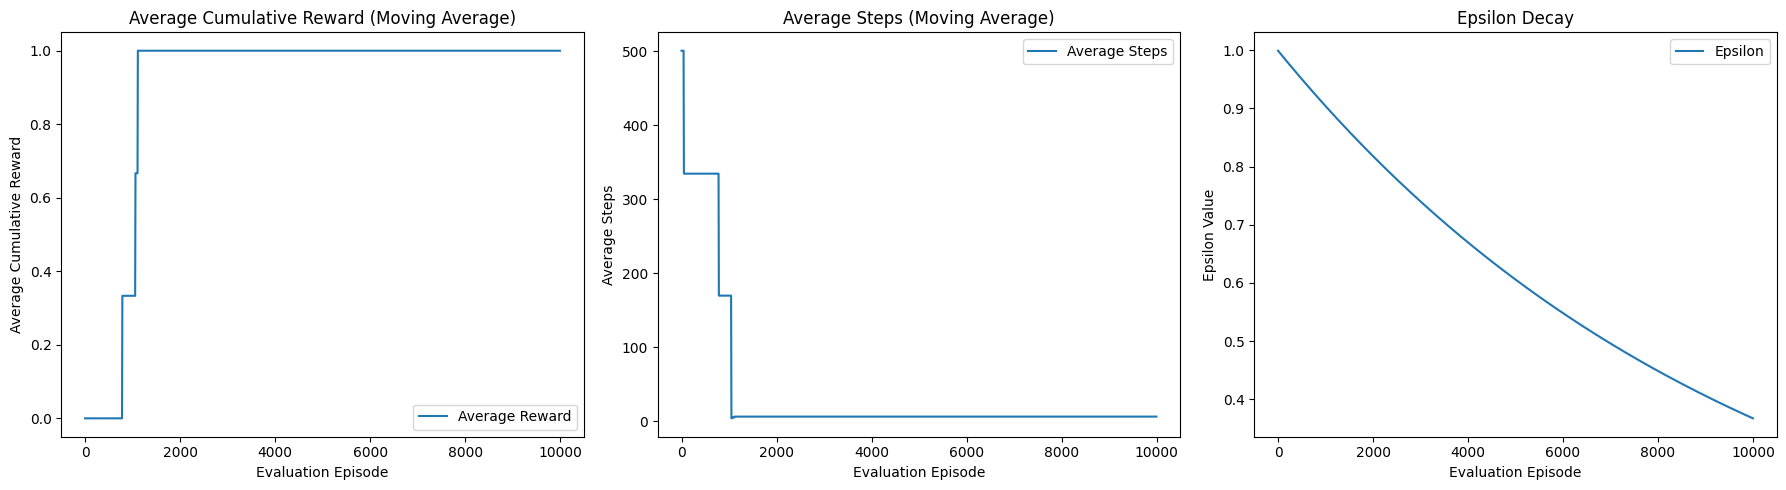

Final Q-Table by taking 72231 steps:
[[0.94148015 0.95099005 0.95099005 0.94148015]
 [0.94148015 0.08706346 0.96059601 0.95069953]
 [0.95089551 0.970299   0.94909369 0.96047555]
 [0.95976114 0.01227887 0.76762779 0.75539276]
 [0.95099005 0.96059601 0.08706346 0.94148015]
 [0.08973334 0.05119609 0.01948828 0.02361816]
 [0.08706343 0.9801     0.01218814 0.95476758]
 [0.02368137 0.02331721 0.07413764 0.04328384]
 [0.96059601 0.01835209 0.970299   0.95099005]
 [0.96059601 0.9801     0.9801     0.08706346]
 [0.97029795 0.99       0.05460217 0.97029644]
 [0.022167   0.03633517 0.02635721 0.01506817]
 [0.02964647 0.00737224 0.04501148 0.08131335]
 [0.01835209 0.9801     0.99       0.970299  ]
 [0.9801     0.99       1.         0.9801    ]
 [0.         0.         0.         0.        ]]


In [42]:
env = gym.make('FrozenLake-v1', is_slippery=False)

num_runs = 3
all_results = []

for run in range(num_runs):
    print(f"Training run {run + 1}")
    q_table, _, rewards, lengths, epsilons, total_steps = train_double_q_learning(env, episodes=10000, eval_episodes=1, eval_every=1)
    all_results.append((rewards, lengths, epsilons))

avg_rewards, avg_lengths, avg_epsilons = average_results(all_results, num_evals=len(all_results[0][0]))

_plot_evaluation(avg_rewards, avg_lengths, avg_epsilons, title="DQL FL4x4 ", window_size=5)
print(f"Final Q-Table by taking {total_steps} steps:")
print(q_table)

Training run 1
Double Q-learning training completed.
Training run 2
The first episode reached to 1 is  1878
The length is  14.0
The epsilon is  0.8278610969636833
Double Q-learning training completed.
Training run 3
The first episode reached to 1 is  4291
The length is  14.0
The epsilon is  0.6503647226000898
Double Q-learning training completed.


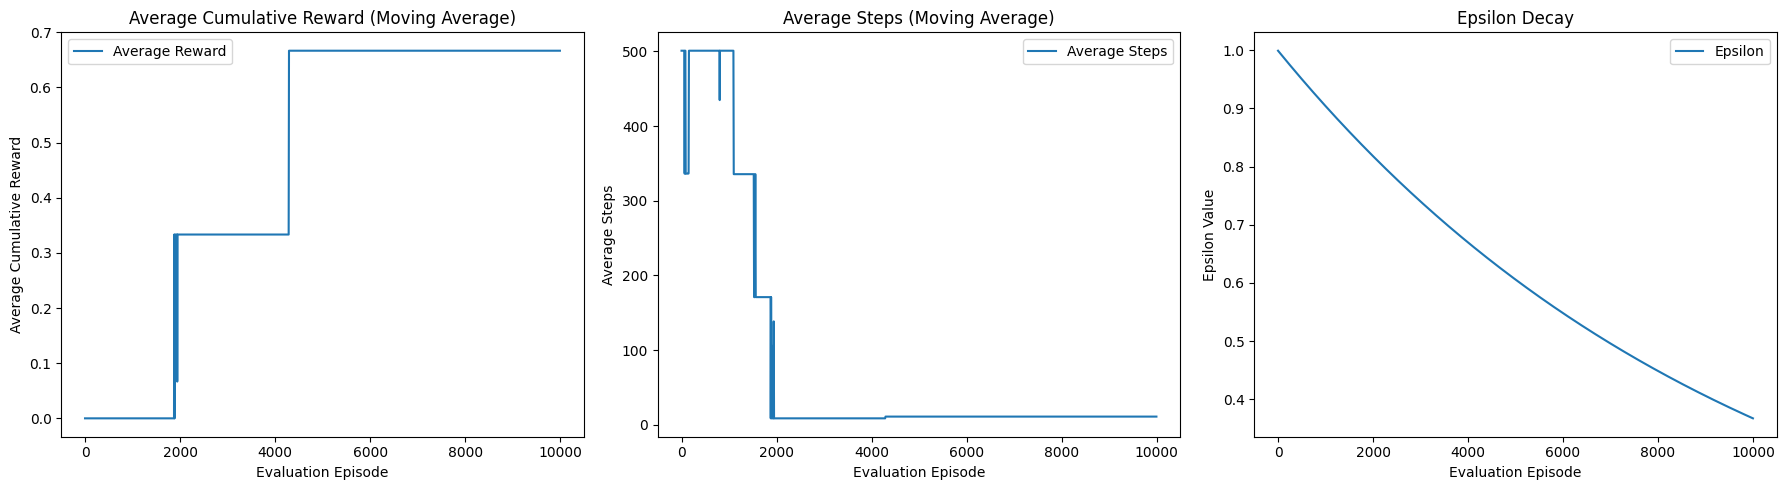

Final Q-Table by taking 234451 steps:
[[0.86874581 0.87752102 0.87752102 0.86874581]
 [0.86874581 0.88638487 0.88638487 0.87752102]
 [0.877521   0.89533825 0.89533822 0.88638483]
 [0.88636963 0.90438208 0.90429386 0.89532418]
 [0.89518895 0.91351725 0.91343245 0.90375249]
 [0.9040969  0.92274469 0.92183985 0.90846474]
 [0.91293321 0.93124673 0.93206535 0.92248001]
 [0.92273877 0.94148015 0.93206493 0.9320595 ]
 [0.87752102 0.86874581 0.88638487 0.86874581]
 [0.87752102 0.87752102 0.89533825 0.87752102]
 [0.88638487 0.88638487 0.90438208 0.88638487]
 [0.89533825 0.06738706 0.91351725 0.89533825]
 [0.90438208 0.92274469 0.92274469 0.90438208]
 [0.91351725 0.93206535 0.93206535 0.91351725]
 [0.92274469 0.94148015 0.94148015 0.92274469]
 [0.93206535 0.95099005 0.94148015 0.93206535]
 [0.86497414 0.85246829 0.87121966 0.87752102]
 [0.86874411 0.86873179 0.88636862 0.88638487]
 [0.87750849 0.87740316 0.06738706 0.89533825]
 [0.04147751 0.09160556 0.00606989 0.02948864]
 [0.06738709 0.9071686

In [43]:
env = gym.make('FrozenLake-v1', map_name="8x8", is_slippery=False)

num_runs = 3
all_results = []

for run in range(num_runs):
    print(f"Training run {run + 1}")
    q_table, _, rewards, lengths, epsilons, total_steps = train_double_q_learning(env, episodes=10000, eval_episodes=1, eval_every=1)
    all_results.append((rewards, lengths, epsilons))

avg_rewards, avg_lengths, avg_epsilons = average_results(all_results, num_evals=len(all_results[0][0]))

_plot_evaluation(avg_rewards, avg_lengths, avg_epsilons, title="DQL FL8x8 ", window_size=5)
print(f"Final Q-Table by taking {total_steps} steps:")
print(q_table)

## Train SQL

In [104]:
def asynchronous_speedy_q_learning(
        env, alpha=0.1, epsilon=1.0, gamma=0.99, total_time_steps=10000,
        eval_every: int = 100,
        eval_episodes: int = 10,         
        epsilon_decay=0.99999,
        min_epsilon = 0.1
):
    state_space = env.observation_space.n
    action_space = env.action_space.n

    # Initialize Q-tables and state visit counts
    Q_k = initialize_random_q_table(env)
    Q_k_minus_1 = np.copy(Q_k)
    k = 0  # Iteration counter
    N = np.zeros((state_space, action_space), dtype=int)
    state = env.reset(seed=1234)[0]
    t = 0
    rewards, lengths, epsilons = [], [], []
    first = True

    lake_map=env.desc
    frozen_lake_binary = np.array(( (lake_map != b'H') & (lake_map != b'G')).astype(int).flatten())

    while t <= total_time_steps:
        action = epsilon_greedy_policy(Q_k, state, epsilon, env)
        next_state, reward, done, _, _ = env.step(action)
        # Update visit count

        eta = 1 / (N[state][action] + 1)

        # Compute temporal differences
        best_next_action_k_minus_1 = np.argmax(Q_k_minus_1[next_state])
        best_next_action_k = np.argmax(Q_k[next_state])
        T_kQ_k_minus_1 = (1 - eta) * Q_k_minus_1[state, action] + eta * (reward + gamma * Q_k_minus_1[next_state, best_next_action_k_minus_1])
        T_kQ_k = (1 - eta) * Q_k[state, action] + eta * (reward + gamma * Q_k[next_state, best_next_action_k])

        # Update Q_k+1
        Q_k_plus_1 = (1 - alpha) * Q_k[state, action] + alpha * (k * T_kQ_k - (k-1) * T_kQ_k_minus_1)
        N[state][action] += 1

        # Update Q-table references
        Q_k_minus_1 = np.copy(Q_k)
        Q_k[state, action] = np.copy(Q_k_plus_1)
        # Move to next state
        state = next_state

        # Check if all state-action pairs have been visited
        if np.min(N[frozen_lake_binary==1]) > 0:
            # print("N got reset")
            k += 1
            alpha = 1 / (k + 1)
            N = np.zeros_like(N)  # Reset visit counts

            # check kon ke satisfy shode ya na
            # another function to find a subset to be greater than the number of possible accessible state

        t += 1

        epsilon = max(min_epsilon, epsilon_decay * epsilon)

        if done:
            state = env.reset(seed=1234)[0]
            
        if (t + 1) % eval_every == 0:
            avg_reward, avg_length = evaluate_policy(env, Q_k, eval_episodes)
            if first and avg_reward:
                first = False
                print("The first total_time_steps reached to 1 is ", t+1)
                print("The length is  ", avg_length)   
                print("The epsilon is  ", epsilon)            
            rewards.append(avg_reward)
            lengths.append(avg_length)
            epsilons.append(epsilon)

    return Q_k, rewards, lengths, epsilons, t+1


Training run 1
The first total_time_steps reached to 1 is  5000
The length is   6.0
The epsilon is   0.9512386990790049
Training run 2
The first total_time_steps reached to 1 is  3000
The length is   6.0
The epsilon is   0.9704550925317743
Training run 3
The first total_time_steps reached to 1 is  3000
The length is   6.0
The epsilon is   0.9704550925317743


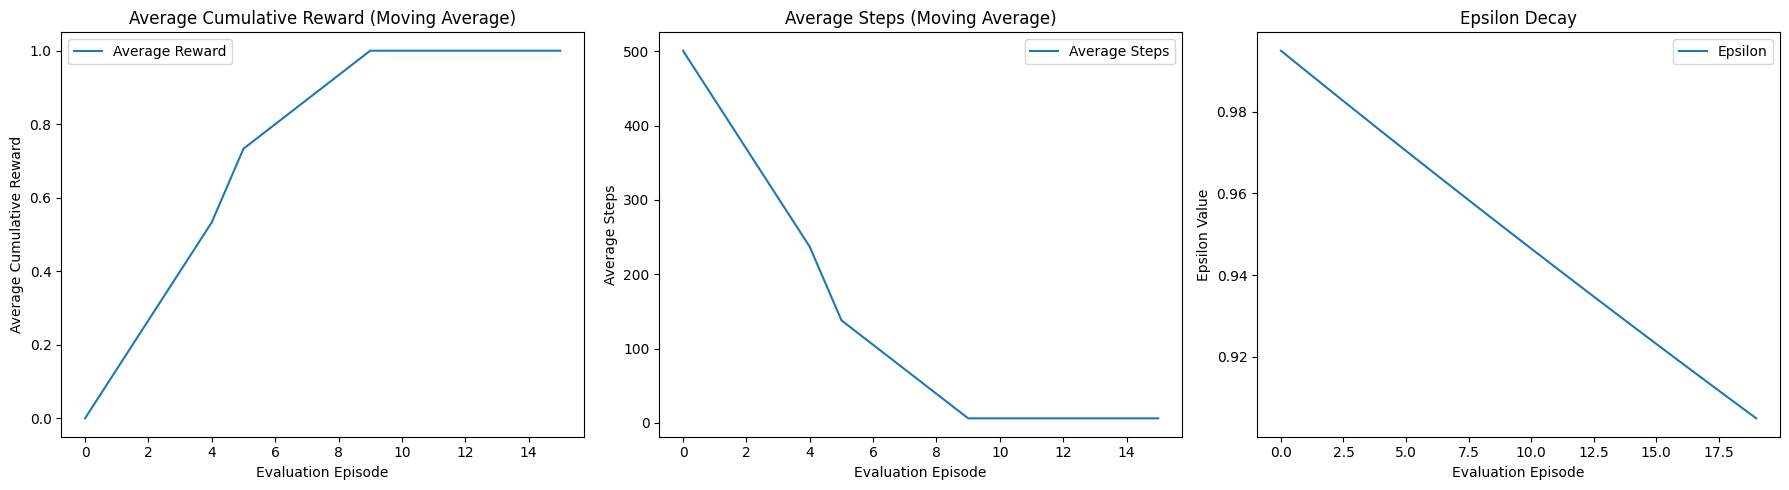

Final Q-Table by taking 10002 steps:
[[0.53133775 0.6092364  0.56066913 0.52105167]
 [0.48205823 0.09629257 0.65386783 0.54929243]
 [0.53452195 0.75634212 0.49348651 0.64057157]
 [0.60850147 0.08961869 0.46586137 0.46086003]
 [0.61021033 0.70449027 0.09655897 0.50555768]
 [0.09754533 0.04303172 0.02279358 0.09339788]
 [0.09643408 0.83643522 0.08959417 0.61459618]
 [0.09061938 0.00697946 0.07568777 0.0276536 ]
 [0.70005452 0.07032977 0.80043911 0.5816736 ]
 [0.66767348 0.81826648 0.88157403 0.09626411]
 [0.74994839 0.95270166 0.07925405 0.70860884]
 [0.00971775 0.04776608 0.08061671 0.00708831]
 [0.06962252 0.07120671 0.02647383 0.01798083]
 [0.0697265  0.74106505 0.92966974 0.70740212]
 [0.80938826 0.87537975 0.99192963 0.82562462]
 [0.         0.         0.         0.        ]]


In [105]:
env = gym.make('FrozenLake-v1', is_slippery=False)

num_runs = 3
all_results = []

for run in range(num_runs):
    print(f"Training run {run + 1}")
    q_table, rewards, lengths, epsilons, total_steps = asynchronous_speedy_q_learning(env, total_time_steps=10000, eval_episodes=1, eval_every=500)
    all_results.append((rewards, lengths, epsilons))

avg_rewards, avg_lengths, avg_epsilons = average_results(all_results, num_evals=len(all_results[0][0]))

_plot_evaluation(avg_rewards, avg_lengths, avg_epsilons, title="SQL FL4x4 ", window_size=5)
print(f"Final Q-Table by taking {total_steps} steps:")
print(q_table)

In [ ]:
env = gym.make('FrozenLake-v1', map_name='8x8', is_slippery=False)

num_runs = 3
all_results = []

for run in range(num_runs):
    print(f"Training run {run + 1}")
    q_table, rewards, lengths, epsilons, total_steps = asynchronous_speedy_q_learning(env, total_time_steps=1000000, eval_episodes=1, eval_every=10000)
    all_results.append((rewards, lengths, epsilons))

avg_rewards, avg_lengths, avg_epsilons = average_results(all_results, num_evals=len(all_results[0][0]))

_plot_evaluation(avg_rewards, avg_lengths, avg_epsilons, title="SQL FL4x4 ", window_size=5)
print(f"Final Q-Table by taking {total_steps} steps:")
print(q_table)

# HYBRID METHODS

In [106]:
def ultimate_sdql_training(env, epsilon=1, min_epsilon=0.1, epsilon_decay=0.999999, T=100000, gamma=0.99, eval_interval=50, eval_episodes=1):
    state_space = env.observation_space.n
    action_space = env.action_space.n

    Q_A = initialize_random_q_table(env)
    Q_B = initialize_random_q_table(env)
    Q_A_minus_1, Q_B_minus_1 = np.copy(Q_A), np.copy(Q_B)

    N_A = np.zeros((state_space, action_space))
    N_B = np.zeros((state_space, action_space))

    rewards, lengths, epsilons = [], [], []

    k_A = k_B = t = 0
    alpha_A = alpha_B = 1

    state = env.reset()[0]

    # hole_indeces = [19,29,35,41,42,46,49,52,54,59]
    # hole_indeces = [5,7,11,12]
    lake_map=env.desc
    frozen_lake_binary = np.array(( (lake_map != b'H') & (lake_map != b'G')).astype(int).flatten())

    first = True
    while t <= T:
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            combined_Q = (Q_A[state, :] + Q_B[state, :]) / 2
            action = np.argmax(combined_Q)

        next_state, reward, done, truncated, info = env.step(action)

        if np.random.rand() < 0.5:  # Update Q_A
            eta = 1 / (N_A[state, action] + 1)
            a_star = np.argmax(Q_A_minus_1[next_state, :])
            a_plus = np.argmax(Q_A[next_state, :])

            T_kQ_A_minus_1 = (1 - eta) * Q_A_minus_1[state, action] + eta * (reward + gamma * Q_B_minus_1[next_state, a_star])
            T_kQ_A = (1 - eta) * Q_A[state, action] + eta * (reward + gamma * Q_B[next_state, a_plus])

            Q_A_minus_1[state, action] = Q_A[state, action]
            Q_A[state, action] = (1 - alpha_A) * Q_A[state, action] + alpha_A * (k_A * T_kQ_A - (k_A - 1) * T_kQ_A_minus_1)
            N_A[state, action] += 1
        else:  # Update Q_B
            eta = 1 / (N_B[state, action] + 1)
            a_star = np.argmax(Q_B_minus_1[next_state, :])
            a_plus = np.argmax(Q_B[next_state, :])
            T_kQ_B_minus_1 = (1 - eta) * Q_B_minus_1[state, action] + eta * (
                        reward + gamma * Q_A_minus_1[next_state, a_star])
            T_kQ_B = (1 - eta) * Q_B[state, action] + eta * (reward + gamma * Q_A[next_state, a_plus])

            Q_B_minus_1[state, action] = Q_B[state, action]
            Q_B[state, action] = (1 - alpha_B) * Q_B[state, action] + alpha_B * (
                        k_B * T_kQ_B - (k_B - 1) * T_kQ_B_minus_1)
            N_B[state, action] += 1

        state = next_state

        # Update counters and learning rates if needed
        if np.min(N_A[frozen_lake_binary == 1]) > 0:
            # print("N_A got reset")
            k_A += 1
            alpha_A = 1 / (k_A + 1)
            N_A.fill(0)  # Reset visit counts for A

        if np.min(N_B[frozen_lake_binary == 1]) > 0:
            # print("N_B got reset")
            k_B += 1
            alpha_B = 1 / (k_B + 1)
            N_B.fill(0)  # Reset visit counts for B

        epsilon = max(min_epsilon, epsilon * epsilon_decay)  # Reduce epsilon
        t += 1
        if done:
            state = env.reset()[0]

        if (t + 1) % eval_interval == 0:
            avg_reward, avg_length = evaluate_policy(env, Q_A, eval_episodes)
            if first and avg_reward:
                first = False
                print(f"Evaluation at step {t + 1}: Avg Reward = {avg_reward}, Avg Length = {avg_length}, epsilon = {epsilon}")

            rewards.append(avg_reward)
            lengths.append(avg_length)
            epsilons.append(epsilon)


    return Q_A, rewards, lengths, epsilons, t+1




Training run 1
Evaluation at step 4500: Avg Reward = 1.0, Avg Length = 6.0, epsilon = 0.995511103100644
Training run 2
Evaluation at step 6000: Avg Reward = 1.0, Avg Length = 6.0, epsilon = 0.9940189550906608
Training run 3
Evaluation at step 4500: Avg Reward = 1.0, Avg Length = 6.0, epsilon = 0.995511103100644


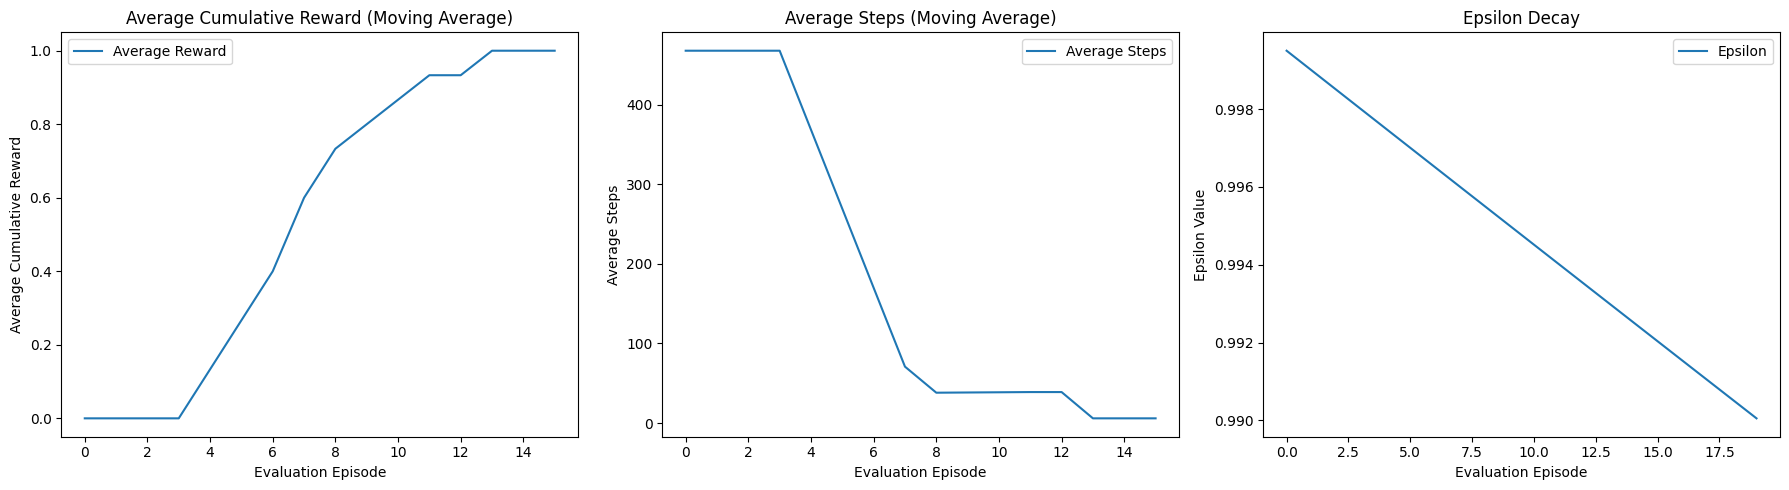

Final Q-Table by taking totally 10002 steps:
[[0.20603223 0.33735873 0.40537668 0.20596403]
 [0.20419464 0.06404308 0.55290631 0.40073444]
 [0.39443854 0.6882514  0.38199626 0.55306104]
 [0.54629914 0.0272526  0.37317371 0.36858861]
 [0.33500144 0.46377618 0.06404572 0.20413607]
 [0.00744483 0.01886056 0.0960959  0.05003285]
 [0.06404572 0.79274331 0.0272526  0.50888662]
 [0.05875536 0.05579183 0.03410858 0.00103265]
 [0.45904801 0.08694384 0.5964911  0.32734107]
 [0.43616239 0.79125184 0.77933797 0.06381747]
 [0.52854825 0.93177637 0.09039658 0.59477869]
 [0.06082426 0.00318936 0.04186703 0.01301527]
 [0.03898397 0.04020027 0.01745678 0.02875555]
 [0.0868335  0.56665555 0.88764666 0.52646006]
 [0.69179241 0.90470555 0.97222292 0.78161174]
 [0.         0.         0.         0.        ]]


In [107]:

env = gym.make('FrozenLake-v1', is_slippery=False)

num_runs = 3
all_results = []

for run in range(num_runs):
    print(f"Training run {run + 1}")
    q_table, rewards, lengths, epsilons, lens = ultimate_sdql_training(env, T=10000, eval_episodes=1, eval_interval=500)
    all_results.append((rewards, lengths, epsilons))

avg_rewards, avg_lengths, avg_epsilons = average_results(all_results, num_evals=len(all_results[0][0]))

_plot_evaluation(avg_rewards, avg_lengths, avg_epsilons, title="SDQL FL4x4 (Averaged over 3 runs)", window_size=5)
print(f"Final Q-Table by taking totally {lens} steps:")
print(q_table)


Training run 1


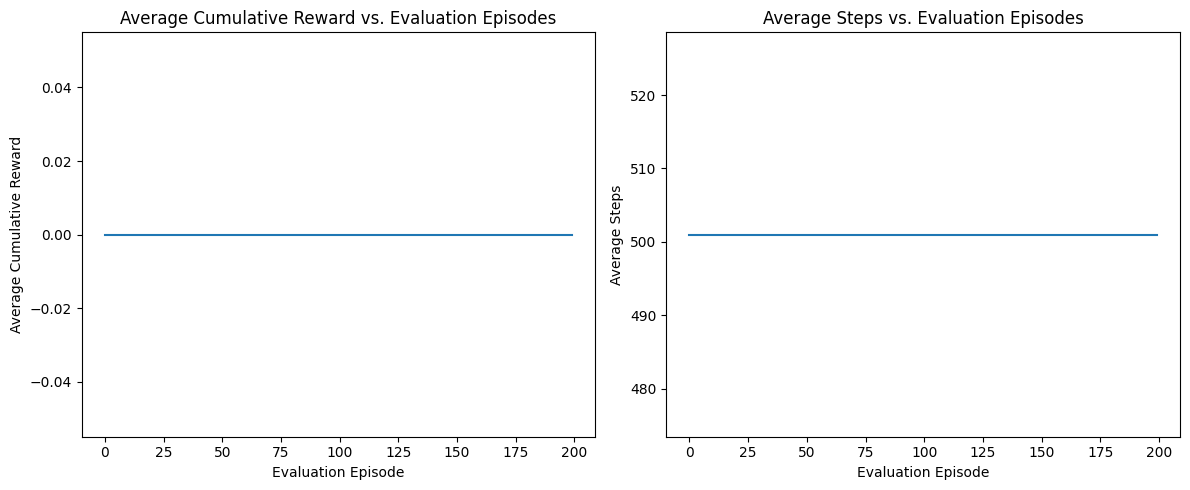

Training run 2


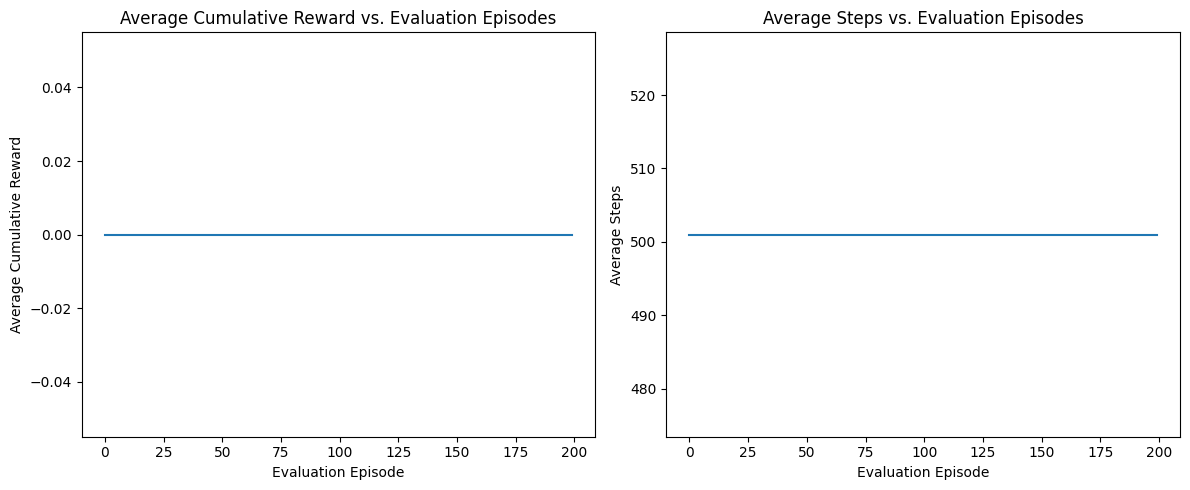

Training run 3


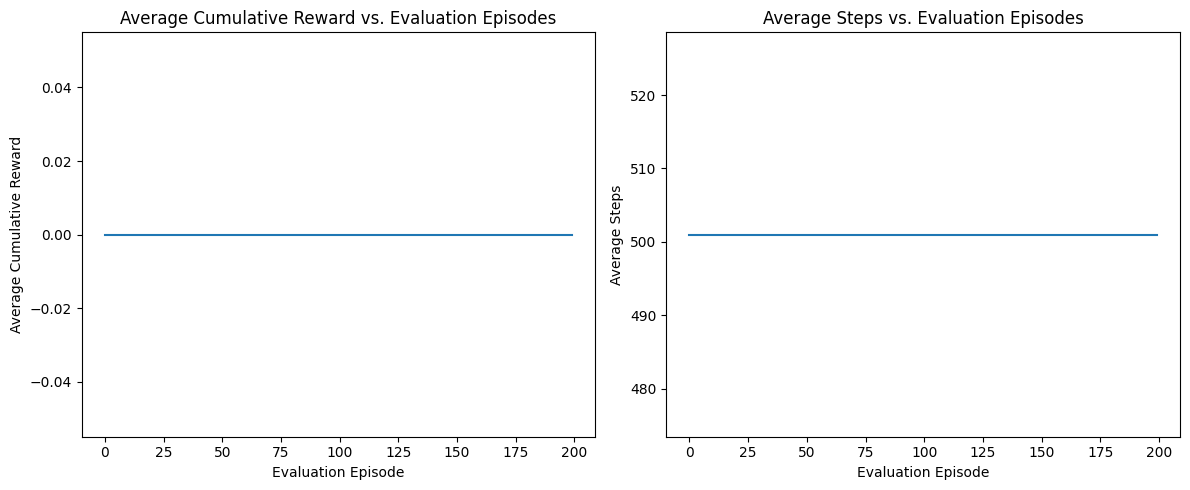

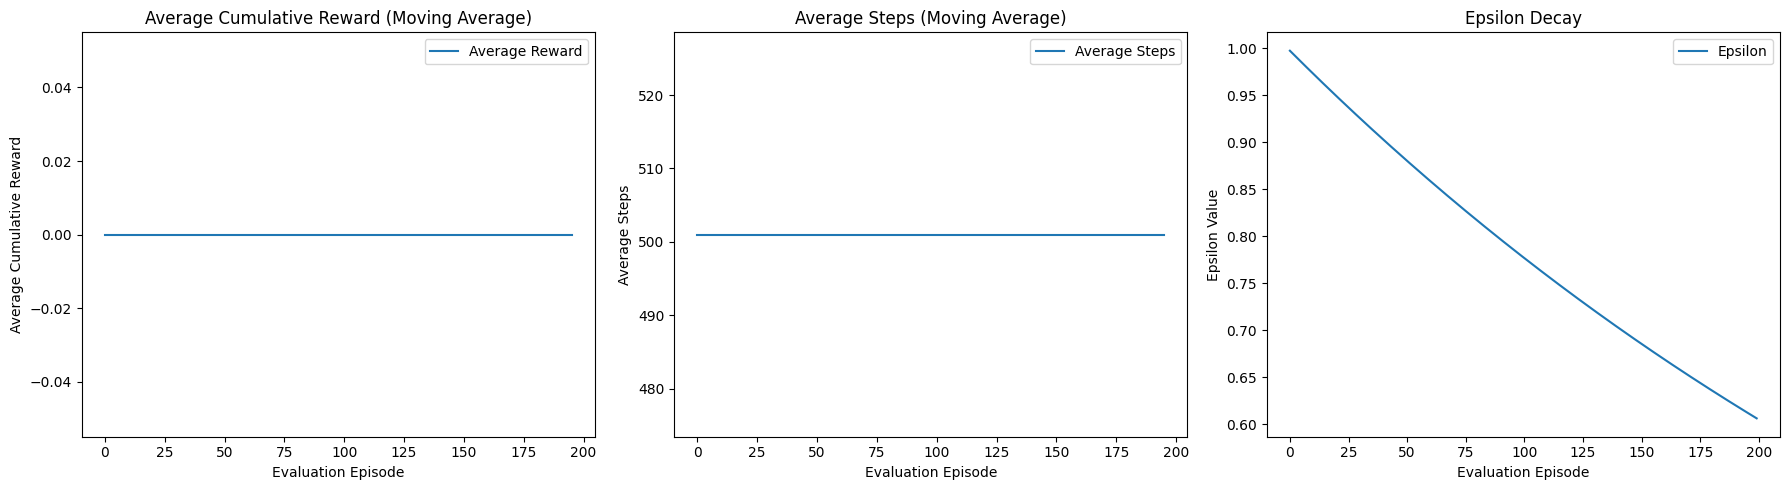

Final Q-Table by taking totally 500002 steps:
[[7.08870072e-02 7.17242782e-02 7.08743821e-02 7.12355816e-02]
 [7.10177854e-02 6.94555950e-02 6.92154569e-02 7.10687584e-02]
 [7.02862838e-02 6.71659569e-02 6.62961141e-02 6.66748980e-02]
 [7.04075975e-02 8.78695196e-02 6.55354370e-02 6.67518864e-02]
 [6.62076710e-02 7.10299816e-02 6.25754464e-02 6.70017753e-02]
 [6.00885878e-02 6.88208475e-02 5.22070915e-02 6.04803544e-02]
 [5.87658011e-02 5.79411127e-02 5.40397993e-02 5.21022347e-02]
 [5.21030479e-02 7.02554081e-02 5.06710450e-02 4.87977956e-02]
 [7.13742107e-02 7.09505071e-02 6.99321721e-02 7.09125772e-02]
 [7.13166978e-02 6.87644462e-02 6.68811956e-02 7.13068893e-02]
 [6.91483272e-02 9.11160987e-02 8.76977850e-02 6.86106511e-02]
 [6.79513770e-02 7.39587585e-02 7.14219026e-02 6.85516963e-02]
 [8.92875563e-02 7.45097584e-02 6.87641699e-02 6.83105950e-02]
 [7.06030308e-02 6.57176796e-02 5.82597128e-02 6.33916671e-02]
 [6.80918226e-02 6.79038872e-02 7.35244933e-02 5.31083086e-02]
 [5.83395

In [116]:

env = gym.make('FrozenLake-v1', map_name='8x8', is_slippery=False)

num_runs = 3
all_results = []

for run in range(num_runs):
    print(f"Training run {run + 1}")
    q_table, rewards, lengths, epsilons, lens = ultimate_sdql_training(env, T=500000, eval_episodes=1, eval_interval=2500)
    plot_metrics(rewards, lengths)
    all_results.append((rewards, lengths, epsilons))

avg_rewards, avg_lengths, avg_epsilons = average_results(all_results, num_evals=len(all_results[0][0]))

_plot_evaluation(avg_rewards, avg_lengths, avg_epsilons, title="SDQL FL8x8 (Averaged over 3 runs)", window_size=5)
print(f"Final Q-Table by taking totally {lens} steps:")
print(q_table)

In [ ]:

def initialize_q_tables(state_space, action_space):
    """Initialize Q-tables Q_0 and Q_{-1}."""
    Q_0 = np.zeros((state_space, action_space))
    Q_minus_1 = np.copy(Q_0)  # Initially, Q_{-1} is the same as Q_0
    return Q_0, Q_minus_1

def epsilon_greedy_policy(Q, state, epsilon):
    """Choose an action based on epsilon-greedy policy."""
    if np.random.random() < epsilon:
        return np.random.randint(Q.shape[1])
    else:
        return np.argmax(Q[state])

def asynchronous_speedy_double_q_learningI(
        env, alpha=0.1, epsilon=0.5, gamma=0.99, total_time_steps=10000,
        eval_every: int = 100,
        eval_episodes: int = 10
):
    state_space = env.observation_space.n
    action_space = env.action_space.n

    lake_map=env.desc
    frozen_lake_binary = np.array(( (lake_map != b'H') & (lake_map != b'G')).astype(int).flatten())
    # print(frozen_lake_binary)
    hole_indeces = np.where(frozen_lake_binary==0)[0]
    
    # Initialize Q-tables and state visit counts
    Q_k, Q_k_minus_1 = initialize_q_tables(state_space, action_space)
    # Q_k = universal_initialize_q_table(env)
    # Q_k_minus_1 = np.copy(Q_k)
    k = 0  # Iteration counter
    N = np.zeros((state_space, action_space), dtype=int)
    state = env.reset()[0]
    t = 0
    rewards, lengths = [], []
    total_reward, steps = 0, 0
    while t < total_time_steps - 1:
        action = epsilon_greedy_policy(Q_k, state, epsilon)
        next_state, reward, done, truncated, info = env.step(action)
        # Update visit count

        N[state][action] += 1
        eta = 1 / N[state][action]

        # Compute temporal differences
        best_next_action_k_minus_1 = np.argmax(Q_k_minus_1[next_state])
        best_next_action_k = np.argmax(Q_k[next_state])
        T_kQ_k_minus_1 = (1 - eta) * Q_k_minus_1[state, action] + eta * (reward + gamma * Q_k_minus_1[next_state, best_next_action_k])
        T_kQ_k = (1 - eta) * Q_k[state, action] + eta * (reward + gamma * Q_k[next_state, best_next_action_k_minus_1])

        # Update Q_k+1
        Q_k_plus_1 = (1 - alpha) * Q_k[state, action] + alpha * (k * T_kQ_k - (k-1) * T_kQ_k_minus_1)

        # Update Q-table references
        Q_k_minus_1 = Q_k
        Q_k[state, action] = Q_k_plus_1
        total_reward += reward
        steps += 1
        # Move to next state
        state = next_state

        # Check if all state-action pairs have been visited
        if np.min(N[hole_indeces]) > 0:
            k += 1
            alpha = 1 / (k + 1)
            N = np.zeros_like(N)  # Reset visit counts

        t += 1

        if done:
            state = env.reset()[0]
            total_reward, steps = 0, 0
        if (t + 1) % eval_every == 0:
            avg_reward, avg_length = evaluate_policy(env, Q_k, eval_episodes)
            rewards.append(avg_reward)
            lengths.append(avg_length)

    return Q_k, rewards, lengths





SDQL I


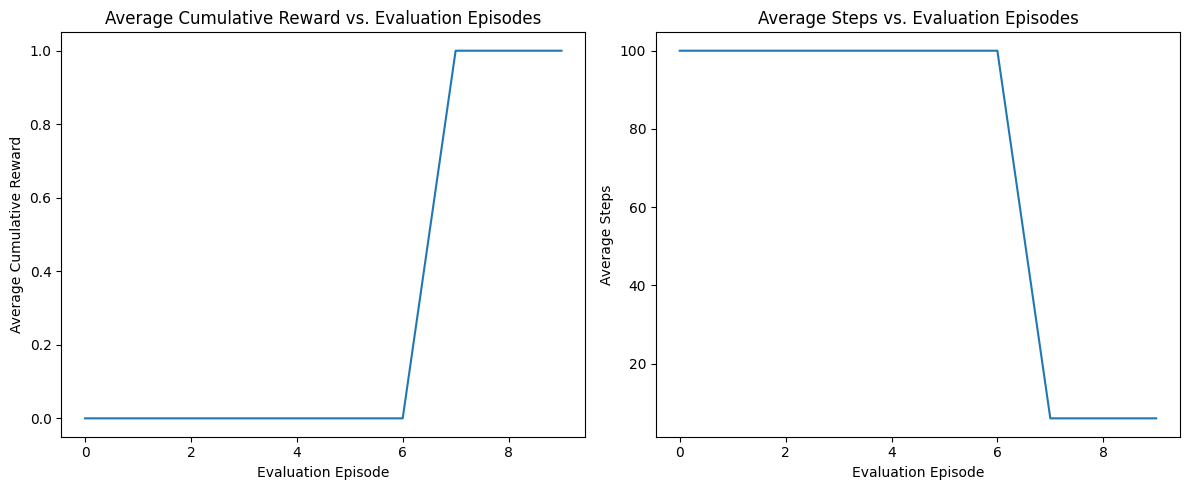

Trained Q-Table:
[[1.19030935e-10 2.16765634e-07 3.49267150e-08 4.46514161e-10]
 [9.70698744e-11 0.00000000e+00 1.25517261e-05 9.80638347e-09]
 [2.50495017e-08 1.01254403e-03 6.62250762e-08 9.28188974e-06]
 [1.42945454e-05 0.00000000e+00 1.81032008e-09 0.00000000e+00]
 [3.21337809e-08 1.77418721e-05 0.00000000e+00 1.01319470e-09]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.52872279e-02 0.00000000e+00 4.63495144e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.39833481e-06 0.00000000e+00 6.52330476e-04 2.23711672e-07]
 [8.76153504e-06 1.27718117e-02 5.88841204e-03 0.00000000e+00]
 [6.38742772e-04 9.47165781e-02 0.00000000e+00 7.44978122e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 8.85084876e-03 1.01743457e-01 7.81394824e-04]
 [1.37666502e-02 8.33406499e-02 4.25853730e-01 1.41527342e-02]
 [0.00000000e+00 0.00000000e+00 0.0000

In [ ]:
# Train the agent using Speedy Double Q Learning I
print("SDQL I")
q_table, rewards, lengths = asynchronous_speedy_double_q_learningI(env, total_time_steps=10000, eval_episodes=1000, eval_every=1000)
_plot_evaluation(rewards, lengths)
# # visualize_frozen_lake(q_table)
print("Trained Q-Table:")
print(q_table)
